## Testing ingested data:

In [13]:
%matplotlib inline
# Various utilities
import shapely.geometry
import IPython.display
import os

from src import utils
# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    os_utils,
    Geometry
)

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")
byoc = SentinelHubBYOC(config=config)

In [14]:
# list all collections
utils.list_byoc_collections()

Collection name: TreeCoverDensity2018_10m_raster
Collection id:  3947b646-383c-4e91-aade-2f039bd6ba4b
-------------------
Collection name: UrbanAtlas2012_10m_raster
Collection id:  47ea75a0-875f-4ee9-ae78-b02be89d43d7
-------------------
Collection name: environmental_zones_1km
Collection id:  5b45916e-6704-4581-824f-4d713198731b
-------------------
Collection name: UrbanAtlas2018_10m_raster
Collection id:  78545a11-1e57-4ed0-a3ce-68c2e305216b
-------------------
Collection name: urban_audit_2021_city
Collection id:  7b4d761f-893b-43be-a4d6-4f37375318d3
-------------------
Collection name: urban_audit_2021_fua
Collection id:  c12e7be5-9f5e-441c-930f-2f274218e6d3
-------------------
Collection name: ImperviousnessDensity2018_10m_raster
Collection id:  c57f7668-2717-4529-93cc-5372bc96ebbe
-------------------
Collection name: nuts3_2021
Collection id:  d0a3f8c5-bf65-4bf2-9a3d-37a1d7101874
-------------------
Collection name: Halle_UA_height
Collection id:  dfad0a7e-9d3a-46e2-9fb6-7940f85b

In [15]:
# make DataCollections to be used in the SentinelHub request
collections_iterator = byoc.iter_collections()
my_collections = list(collections_iterator)
DataCollection_list = []
for collection in my_collections:
    DataCollection_list.append(DataCollection.define_byoc(collection["id"], name=collection["name"]))

ValueError: Data collection name 'urban_audit_2021_city' is already taken by another data collection

In [16]:
for collection in DataCollection.get_available_collections():
    print(collection)

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.TreeCoverDensity2018_10m_raster
DataCollection.UrbanAtlas2012_10m_raster
DataCollection.environmental_zones_1km
DataCollection.UrbanAtlas2018_10m_raster
DataCollection.urban_audit_2021_city
Da

## Get geometry and bounding box
### Get from database


In [39]:
print (" import data")

################################################## SET postgre-sql connection:

from src import db_connect
import os
import pandas as pd
import geopandas as gpd
from sqlalchemy import text

home_dir = os.environ.get('HOME')
engine_postgresql = db_connect.create_engine(db_config = f"{home_dir}/uc1-urban-climate/database.ini")

with engine_postgresql.begin() as conn:
    query = text("""
              SELECT urau_code, urau_name, geometry
            FROM lut.l_city_urau2021
            """)
    gdf = gpd.read_postgis(query, conn, geom_col='geometry')

row = gdf[gdf.urau_name == 'Cosenza']
geometry_gdf = row.geometry # input argument
bbox_coords = geometry_gdf.bounds.minx, geometry_gdf.bounds.miny, geometry_gdf.bounds.maxx, geometry_gdf.bounds.maxy # input argument (or compute from geometry)
geometry = Geometry(geometry=geometry_gdf.item(), crs=CRS.WGS84)
bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
bbox_size = bbox_to_dimensions(bbox, resolution=10)

 import data


### Alternatively, define your own bounding box

In [18]:
# x1 = 18# degree
# y1 = 41.60  # degree
# x2 = 20.34 # degree
# y2 = 40  # degree

# x1 = 6  # degree
# y1 = 49  # degree
# x2 = 6.9 # degree
# y2 = 49.9  # degree

# bbox = BBox([x1, y1, x2, y2], crs=CRS.WGS84)
# bbox_size = bbox_to_dimensions(bbox, resolution=10)

### Print bounding box

In [40]:
print(f"Image shape at {10} m resolution: {bbox_size} pixels")
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

Image shape at 10 m resolution: (899, 1155) pixels


<IPython.display.GeoJSON object>

## Send request and display the result

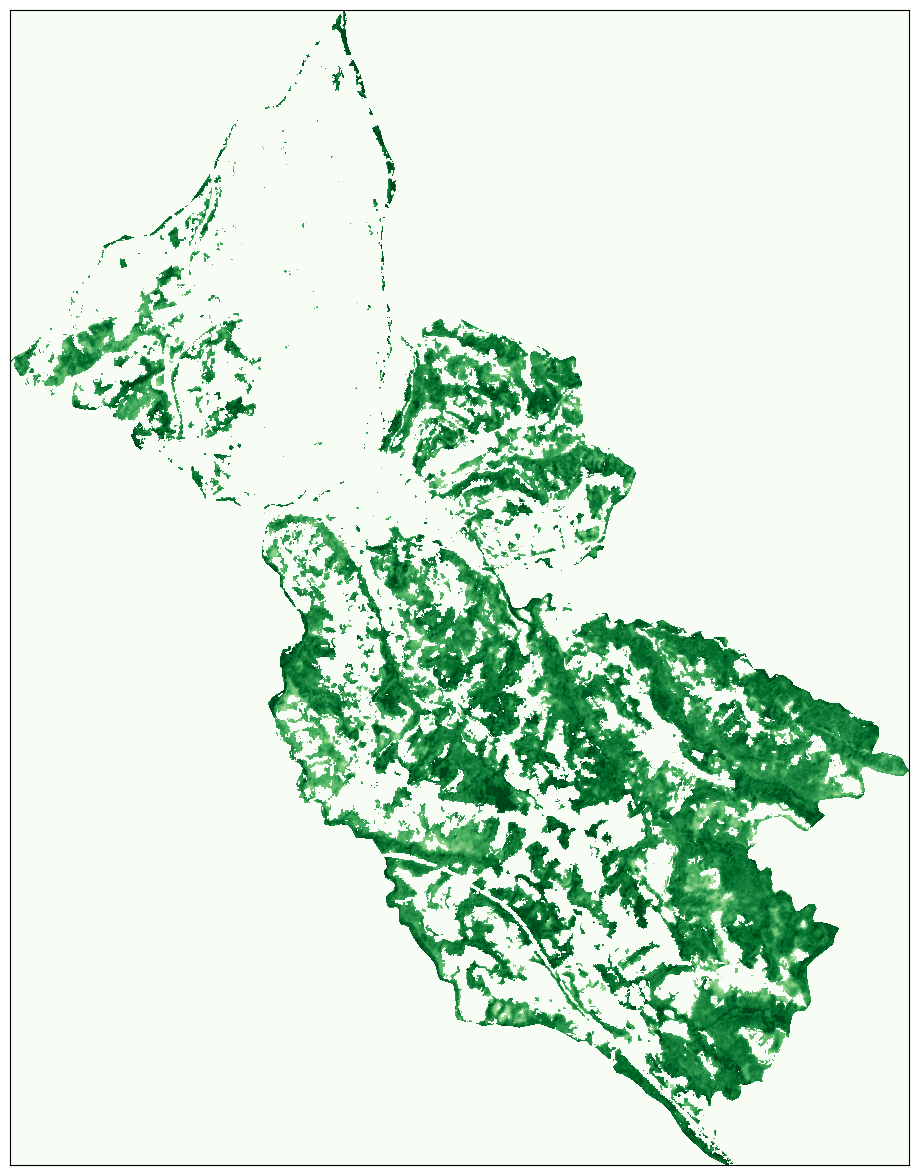

In [43]:
#https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html
#https://eurodatacube.com/notebooks/contributions/LPIS_LULC-Slo.ipynb



evalscript_test = """

//VERSION=3
function setup() {
  return {
    input: ["B01"],
    output: { 
        bands: 1,
        sampleType: "UINT16" // raster format will be UINT16
        }
    
  };
}

function evaluatePixel(sample) {
  return [sample.B01];
}
"""

request = SentinelHubRequest(
        evalscript=evalscript_test,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.TreeCoverDensity2018_10m_raster,
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
    geometry=geometry,
        size=bbox_to_dimensions(bbox, 10),
        config=config
    )
data = request.get_data()[0]
utils.plot_image(data, cmap='Greens')

In [57]:
import numpy as np
print(np.unique(data))

[ 0  5 11 12 13]


In [56]:
data

array([[ 0,  0,  0, ...,  5,  5,  5],
       [ 0,  0,  0, ...,  5,  5,  5],
       [ 0,  0,  0, ...,  5,  5,  5],
       ...,
       [13, 13, 13, ..., 11, 11, 11],
       [13, 13, 13, ..., 11, 11, 11],
       [13, 13, 13, ..., 11, 11, 11]], dtype=uint16)